__Batch run for zonal stats__ \
Tips from: https://gorelick.medium.com/fast-er-downloads-a2abd512aa26

## I/O

In [1]:
import os
import multiprocessing
import numpy as np
from scipy.stats import binned_statistic

from retry import retry
import geopandas as gpd
import pandas as pd
import dask.dataframe as dd
import ee
import geemap

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
analysis_dir = '/mnt/g/Ch4/GSW_zonal_stats/v2/'
os.makedirs(analysis_dir, exist_ok=True)

In [3]:
## Register with ee using high-valume (and high-latency) endpoint
ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')

## Functions

In [4]:
def getRequests():
    """Generates a list of work items to be downloaded.
    Funnily enough, equivalent  to np.arange(-179.75, 179.75, 0.5)
    """    
    ## Load BAWLD
    bawld = ee.FeatureCollection('projects/ee-ekyzivat/assets/Shapes/BAWLD/bawld_grid')

    # For testing: Filter BAWLD to reduce size of operation
    # bawldF = bawld.filter("Lat > 59").filter("Lat < 60") #.filter("Long == -126.25")

    ## Aggregate by Longitude
    return np.unique(bawld.aggregate_array('Long').getInfo()) # change to bawld not bawldF for real run

In [5]:
@retry(tries=10, delay=1, backoff=2) # (tries=10, delay=1, backoff=2)
def getResult(index, long):
    """Handle the HTTP requests to download one result. index is python index and long is longitude, used for aggregation."""
    
    ## I/O
    out_dir = os.path.join(analysis_dir, 'tiles')
    out_pth = os.path.join(out_dir, f'bawld_zStats_Oc_Long{long:06.5}.csv')

    ## CRS (ist there a smarter way to do this?)
    crs = 'PROJCS["Lambert_Azimuthal_Equal_Area",GEOGCS["Unknown",DATUM["D_unknown",SPHEROID["Unknown",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_origin",45.5],PARAMETER["central_meridian",-114.125],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1]]'
    # crs = 'PROJCS["WGS 84 / NSIDC EASE-Grid 2.0 North",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",90],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AUTHORITY["EPSG","6931"]]'

    ## Load BAWLD
    bawld = ee.FeatureCollection('projects/ee-ekyzivat/assets/Shapes/BAWLD/bawld_grid')

    ## Load GSW
    gsw = ee.Image("JRC/GSW1_4/GlobalSurfaceWater")
    occurrence = gsw.select('occurrence')

    ## Filter based on longitude bin, specified as variable 'long'
    bawldF = bawld.filter(ee.Filter.eq("Long", long))

    # statistics_type can be either 'SUM' or 'PERCENTAGE'
    # denominator can be used to convert square meters to other areal units, such as square kilometers
    geemap.zonal_statistics_by_group(
        occurrence,
        bawldF,
        out_pth,
        statistics_type='SUM',
        denominator=1000000,
        decimal_places=3,
        crs=crs,
        scale=30, # meters, specifiy to compute at native res (default would be 300m)
        tile_scale=1 # default is 1, but it exceeds GEE capacity
    )

    print("Done with Longitude: ", long)

## Apply functions via GEE calls in parallel

In [6]:
## View expected number of results
items = getRequests()
len(items)


691

In [7]:
## Run function
items = getRequests()
print(f'Sending request in {len(items)} chunks...')
pool = multiprocessing.Pool(25)
pool.starmap(getResult, enumerate(items))
pool.close()
pool.join()

Sending request in 691 chunks...
Computing (Hi Ethan!)... 
Computing (Hi Ethan!)... Computing (Hi Ethan!)... 
Computing (Hi Ethan!)... 

Computing (Hi Ethan!)... 
Computing (Hi Ethan!)... 
Computing (Hi Ethan!)... 
Computing (Hi Ethan!)... 
Computing (Hi Ethan!)... 
Computing (Hi Ethan!)... Computing (Hi Ethan!)... Computing (Hi Ethan!)... Computing (Hi Ethan!)... Computing (Hi Ethan!)... Computing (Hi Ethan!)... 
Computing (Hi Ethan!)... Computing (Hi Ethan!)... Computing (Hi Ethan!)... Computing (Hi Ethan!)... 


Computing (Hi Ethan!)... Computing (Hi Ethan!)... 




Computing (Hi Ethan!)... Computing (Hi Ethan!)... 
Computing (Hi Ethan!)... 



Computing (Hi Ethan!)... 

Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Generating URL ...
Please wait ...
Generating URL ...
Please wait ...
Please wait ...
Ple

## Load and piece together

In [3]:
# Load files using dask
# from https://mungingdata.com/pandas/read-multiple-csv-pandas-dataframe/
tile_dir = os.path.join(analysis_dir, 'tiles')
ddf = dd.read_csv(f"{tile_dir}/*.csv", dtype={'system:index': 'object'}) # latter argument suggested by dask error and it fixes it!

In [4]:
## convert to pandas df
df = ddf.compute()
df = df.reset_index().drop('index', axis=1)
df

,Class_sum,FEN_H,FEN_L,MPL,MYL_L,SPL,LAK_L,MYL_H,WTU_H,WTU_L,...,Class_40,Class_41,Class_42,Class_43,Class_44,Class_45,Class_46,Class_47,Class_48,Class_49
0,0.000,2.85,0.78,0.00,0.0,0.00,0.00,0.02,1.39,0.23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000,1.63,0.43,0.00,0.0,0.00,0.00,0.05,1.18,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.000,1.15,0.03,0.00,0.0,0.00,0.04,0.00,1.22,0.08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.000,1.15,0.00,0.00,0.0,0.01,0.13,0.01,1.67,0.53,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.000,1.40,0.39,0.00,0.0,0.00,0.00,0.05,1.39,0.61,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23464,61.259,0.02,0.00,0.81,0.0,0.06,7.65,0.77,6.20,4.37,...,0.161,0.115,0.117,0.113,0.123,0.101,0.101,0.134,0.066,0.017
23465,18.659,0.44,0.00,0.13,0.0,0.00,0.86,0.12,0.47,0.00,...,0.028,0.017,0.020,0.007,0.020,0.014,0.015,0.011,0.000,0.000
23466,54.171,0.00,0.00,0.00,0.0,0.00,1.20,0.03,2.03,0.77,...,0.155,0.146,0.144,0.151,0.136,0.142,0.149,0.145,0.142,0.102
23467,10.067,0.73,0.00,0.00,0.0,0.46,0.97,1.08,9.46,7.43,...,0.010,0.009,0.006,0.007,0.005,0.010,0.010,0.007,0.008,0.003


## Bin GSW in 4 bins

In [5]:
## Mask in occurence columns and change values to int
oc_columns = list(map(lambda c: ('Class_' in c) and ('sum' not in c), df.columns)) # occurrence columns positive mask. use map function, rather than for loop, for practice!
oc_column_vals = list(map(lambda c: int(c.replace('Class_', '')), df.columns[oc_columns])) # all relevant occurance fields converted to ints, as a list
oc_column_vals

[70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 8,
 78,
 7,
 79,
 9,
 0,
 2,
 1,
 4,
 3,
 6,
 5,
 80,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 92,
 93,
 94,
 95,
 96,
 97,
 10,
 98,
 11,
 99,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 100,
 90,
 91,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49]

In [6]:
bStat = binned_statistic(oc_column_vals, values=df.iloc[:, oc_columns], statistic=np.nansum, bins=[0, 5, 50, 95, 100]) # 

In [7]:
bStat

BinnedStatisticResult(statistic=array([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       ...,
       [4.4530e+00, 1.0248e+01, 3.9117e+01, 3.5300e-01],
       [1.1000e-02, 2.1300e-01, 1.3630e+00, 8.4800e+00],
       [3.8720e+00, 9.6590e+00, 1.4570e+01, 8.5800e-01]]), bin_edges=array([  0.,   5.,  50.,  95., 100.]), binnumber=array([3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 2, 1, 1, 1, 1, 1, 2, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 2, 4, 2, 4, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]))

In [8]:
bin_labels = ['0-5', '5-50', '50-95', '95-100']
dfB = pd.DataFrame(bStat.statistic, columns=bin_labels) / pd.DataFrame(df.loc[:,'Class_sum']).values * 100 #, index=df.index) # df binned
dfB['Cell_ID'] = df.Cell_ID
dfB['Class_sum'] = df.Class_sum
dfB 

,0-5,5-50,50-95,95-100,Cell_ID,Class_sum
0,NaN,NaN,NaN,NaN,17920,0.000
1,NaN,NaN,NaN,NaN,17527,0.000
2,NaN,NaN,NaN,NaN,17919,0.000
3,NaN,NaN,NaN,NaN,17526,0.000
4,NaN,NaN,NaN,NaN,17918,0.000
...,...,...,...,...,...,...
23464,0.313423,9.554514,36.097553,54.034509,18122,61.259
23465,0.000000,2.792218,32.198939,65.008843,1163,18.659
23466,8.220265,18.917871,72.210223,0.651640,14730,54.171
23467,0.109268,2.115824,13.539287,84.235621,18464,10.067


## Load shapefile and join in GSW values (full and binned)

In [9]:
## Load shapefile to join
gdf_bawld = gpd.read_file('/mnt/g/Other/Kuhn-olefeldt-BAWLD/BAWLD/BAWLD_V1___Shapefile.zip')


ERROR 1: PROJ: proj_create_from_database: Open of /home/ekyzivat/mambaforge/envs/geospatial/share/proj failed


In [10]:
## Filter columns
cols_to_keep = df.columns[[('Class' in c) or ('Cell_ID' in c) for c in df.columns]]


In [11]:

## Merge files
gdf_join_full = gdf_bawld.merge(df[cols_to_keep], left_on='Cell_ID', right_on='Cell_ID', validate='one_to_one')

In [17]:
## Write out full shapefile
gdf_join_full_pth = os.path.join(analysis_dir, 'bawld_zStats_Oc_full.shp')
gdf_join_full.to_file(gdf_join_full_pth)

In [18]:
gdf_bawld.columns

Index(['Cell_ID', 'Long', 'Lat', 'Area_Pct', 'Shp_Area', 'GLA', 'ROC', 'TUN',
       'BOR', 'WET', 'PEB', 'WTU', 'MAR', 'BOG', 'FEN', 'LAK', 'LAL', 'MPL',
       'MYL', 'MGL', 'SPL', 'SYL', 'SGL', 'RIV', 'LAR', 'SRR', 'SRP', 'GLA_L',
       'GLA_H', 'ROC_L', 'ROC_H', 'TUN_L', 'TUN_H', 'BOR_L', 'BOR_H', 'WET_L',
       'WET_H', 'PEB_L', 'PEB_H', 'WTU_L', 'WTU_H', 'MAR_L', 'MAR_H', 'BOG_L',
       'BOG_H', 'FEN_L', 'FEN_H', 'LAK_L', 'LAK_H', 'LAL_L', 'LAL_H', 'MPL_L',
       'MPL_H', 'MYL_L', 'MYL_H', 'MGL_L', 'MGL_H', 'SPL_L', 'SPL_H', 'SYL_L',
       'SYL_H', 'SGL_L', 'SGL_H', 'RIV_L', 'RIV_H', 'LAR_L', 'LAR_H', 'SRR_L',
       'SRR_H', 'SRP_L', 'SRP_H', 'WETSCAPE', 'geometry'],
      dtype='object')

In [19]:
## Merge binned file to bawld gdf (only keep a few original bawld attributes)
gdf_join_binned = gdf_bawld[['Cell_ID', 'Long', 'Lat', 'Area_Pct', 'Shp_Area', 'WETSCAPE', 'geometry']].merge(dfB, left_on='Cell_ID', right_on='Cell_ID', validate='one_to_one')
gdf_join_binned

,Cell_ID,Long,Lat,Area_Pct,Shp_Area,WETSCAPE,geometry,0-5,5-50,50-95,95-100,Class_sum
0,7265,165.75,61.25,100.00,1.495458e+09,11,"POLYGON ((774650.577 3106953.763, 801734.023 3...",9.863702,53.371593,36.728838,0.035868,2.788
1,14494,61.25,67.75,100.00,1.178664e+09,1,"POLYGON ((2193307.808 -1190868.976, 2182832.13...",11.768931,32.611243,55.576349,0.043477,52.902
2,3598,51.25,57.25,42.39,7.103697e+08,14,"POLYGON ((2800176.939 -2227361.310, 2816190.99...",67.612688,25.375626,7.011686,0.000000,0.599
3,4863,122.25,58.75,100.00,1.612116e+09,14,"POLYGON ((2927361.809 1864935.151, 2943524.767...",4.092769,81.446112,14.324693,0.136426,0.733
4,19124,-99.25,73.25,100.00,8.978315e+08,11,"POLYGON ((-1865353.640 312153.145, -1810905.60...",4.573525,27.913397,39.479802,28.033275,27.528
...,...,...,...,...,...,...,...,...,...,...,...,...
23464,15725,109.25,68.75,100.00,1.128386e+09,14,"POLYGON ((2249390.723 796551.032, 2256256.204 ...",74.146098,20.493642,5.360259,0.000000,4.011
23465,19170,-55.25,73.25,71.63,6.430669e+08,11,"MULTIPOLYGON (((-1553498.751 -1078714.707, -15...",0.081837,3.193358,41.863161,54.861644,117.306
23466,2935,-96.75,56.25,100.00,1.725546e+09,1,"POLYGON ((-3714031.925 423160.487, -3710197.78...",1.096026,6.181609,23.404030,69.318335,170.069
23467,6335,-137.25,60.75,100.00,1.519037e+09,11,"POLYGON ((-2220571.089 2381270.954, -2199706.2...",1.538269,10.503959,36.506177,51.451595,64.033


In [23]:
## Write out binned shapefile
gdf_join_binned_pth = os.path.join(analysis_dir, 'bawld_zStats_Oc_binned.shp')
gdf_join_binned.to_file(gdf_join_binned_pth)

## Histogram plots

In [ ]:
## Re-load dataset, if necessary
# gdf_join_binned = gpd.read_file(gdf_join_binned_pth)

In [26]:
gdf_join_binned[['Cell_ID']+bin_labels].melt(id_vars='Cell_ID', var_name='Occurrence bin')

,Cell_ID,Occurrence bin,value
0,7265,0-5,9.863702
1,14494,0-5,11.768931
2,3598,0-5,67.612688
3,4863,0-5,4.092769
4,19124,0-5,4.573525
...,...,...,...
93871,15725,95-100,0.000000
93872,19170,95-100,54.861644
93873,2935,95-100,69.318335
93874,6335,95-100,51.451595


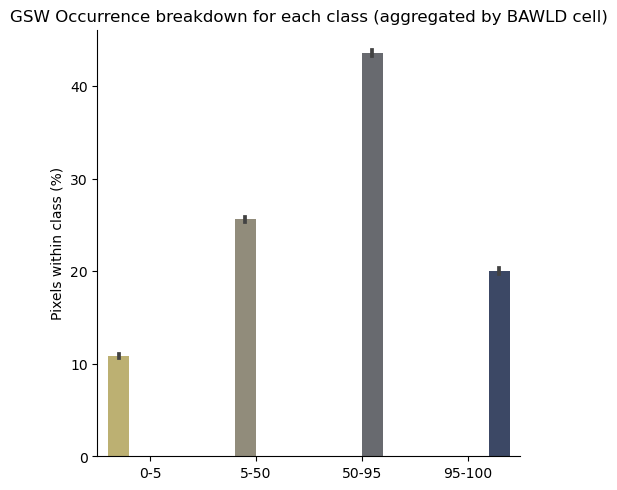

In [25]:
## Plot binned data
## Reshape (melt) and plot as grouped bar plot
"Within all of one occurrence bin, what was the contribution of LEV values"
g = sns.catplot(gdf_join_binned[['Cell_ID']+bin_labels].melt(id_vars='Cell_ID', var_name='Occurrence bin'),\
     hue = 'Occurrence bin', y='value', x='Occurrence bin', kind='bar', palette='cividis_r')
g.set_axis_labels('', 'Pixels within class (%)')
g.set(title=f'GSW Occurrence breakdown for each class (aggregated by BAWLD cell)')

In [32]:
df.iloc[:, oc_columns].tail(3)

,Class_70,Class_71,Class_72,Class_73,Class_74,Class_75,Class_76,Class_77,Class_8,Class_78,...,Class_40,Class_41,Class_42,Class_43,Class_44,Class_45,Class_46,Class_47,Class_48,Class_49
23466,0.178,0.201,0.206,0.214,0.220,0.242,0.240,0.265,0.453,0.290,...,0.155,0.146,0.144,0.151,0.136,0.142,0.149,0.145,0.142,0.102
23467,0.008,0.009,0.008,0.006,0.010,0.014,0.009,0.013,0.003,0.010,...,0.010,0.009,0.006,0.007,0.005,0.010,0.010,0.007,0.008,0.003
23468,0.226,0.226,0.231,0.238,0.244,0.265,0.248,0.285,0.370,0.262,...,0.207,0.178,0.182,0.167,0.174,0.178,0.196,0.185,0.180,0.146


In [12]:
## Create normalized (by total pixels in cell), but non-binned (raw) occurrence values
dfN = df.iloc[:, oc_columns] / pd.DataFrame(df.loc[:,'Class_sum']).values * 100 # note columns are not sorted

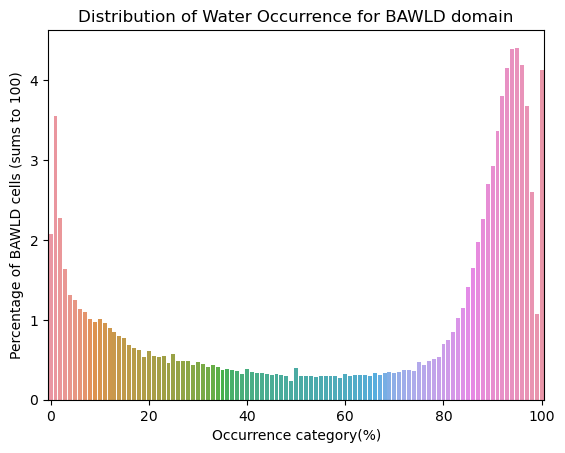

In [16]:
## Non-binned
sns.barplot(x=oc_column_vals, y=dfN.mean())
plt.title('Distribution of Water Occurrence for BAWLD domain')
plt.xticks(ticks=plt.xticks()[0][::20])
plt.xlabel('Occurrence category (%)')
plt.ylabel('Percentage of BAWLD cells (sums to 100)')
plt.show()

In [ ]:
## TODO: why don't these two hist plots have same shape? How to account for non-regular BAWLD grid cell areas? Check total areas. RUN HYDROLAKES calculation for real (figure out how to chunk)!